In [1]:
import imgaug

In [2]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split

from brainseg.generator import TrainGenerator, TestGenerator
from brainseg.loader import Loader
from brainseg.utils import load_data, show_batch_bires
from brainseg.image_provider import BiResImageHandler
from brainseg.provider import provider, DataHandler
from brainseg.streamlit.manager import list_all
from brainseg.slidedata.slides import find_slides_in_dir
from brainseg.slidedata.patch import create_patch, save_patch, load_patch, exists_patch
from brainseg.slidedata.mask import exists_mask_as_image
from brainseg.models.multires_unet4 import multires_unet

import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import basename
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from brainseg.utils import to_color, rgb_to_multi
from PIL import Image
from pathlib import Path

sm.set_framework("tf.keras")

Segmentation Models: using `keras` framework.


In [3]:
STAIN = "CB"

root = Path("/media/moi/LaCie/Data/CZI/atlas_folder_backup")

# for cv (nissl)
# root = Path("/media/moi/LaCie/Data/CZI/czi_split5x")

data_root = Path(f"/media/moi/LaCie/Data/slidedata/mask_mashimoto/{STAIN}")

Path(data_root).mkdir(parents=True, exist_ok=True)

slides = find_slides_in_dir(root)

# for all but cv
czis = list(filter(lambda x: STAIN in basename(x), slides))

# czis = slides

### Generate patches

In [4]:
def generate_patches(slides, root):
    for slide_path in slides:
        if not exists_patch(root, slide_path, name="patch_x8_s224"):
            patches = create_patch(slide_path, 8, 224, 224)
            save_patch(root, slide_path, patches, name="patch_x8_s224")
            
generate_patches(czis, data_root)

### Load patches

In [5]:
def load_patches(slides, root):
    return sum([load_patch(root, slide_path, name="patch_x8_s224")
                for slide_path in slides if exists_mask_as_image(root, slide_path, "mask")], [])

patches = [("multi_slide_mask", {"downscales": [32], **x}) for x in load_patches(czis, data_root)]

In [6]:
len(patches)

10872

## Build Handler

In [7]:
from brainseg.slide_provider_top_left import MultiSlideMaskHandler

In [8]:
handler = MultiSlideMaskHandler(czis, data_root, "mask")

In [9]:
provider.register(handler)

In [10]:
patches[0]

('multi_slide_mask',
 {'downscales': [32],
  'slide_name': 'p50_M150_LHRH_198_KA198_CB.czi',
  'origin': (0, 0),
  'downsample': 8,
  'step': 224,
  'size': 224})

In [11]:
n = 3
img = provider.image(patches[n])
arr = provider.mask(patches[n])

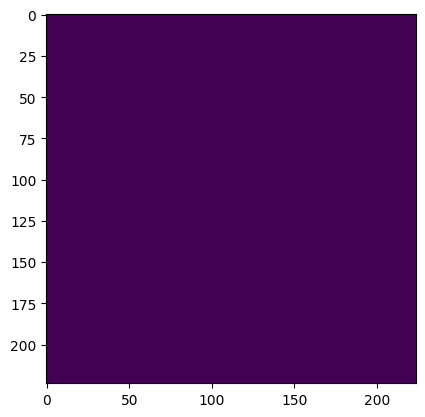

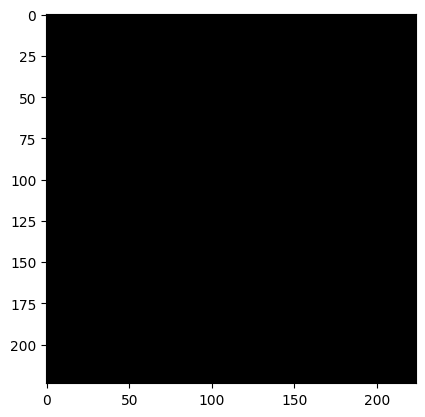

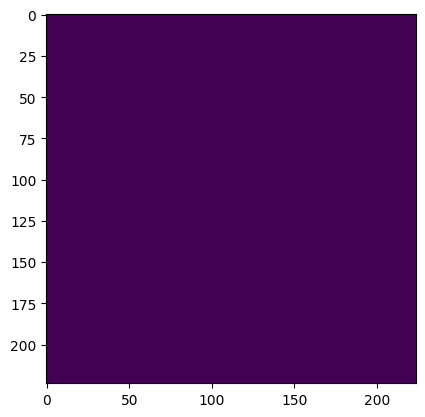

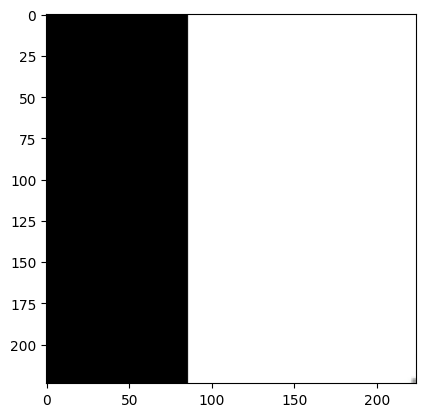

In [12]:
plt.imshow(arr[0])
plt.show()
plt.imshow(img[0] / 255.)
plt.show()
plt.imshow(arr[1])
plt.show()
plt.imshow(img[1] / 255.)

In [13]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Rot90([0, 1, 2, 3]),
])

In [14]:
def preprocess_augment(x, y):
    x = list(map(np.asarray, x))
    y = list(map(np.asarray, y))

    # y = rgb_to_multi(y, colors)

    
    seg = map(lambda mask: SegmentationMapsOnImage(mask, shape=mask.shape), y)
    current_seq = seq.to_deterministic()
    
    x, y = zip(*map(lambda a: current_seq(image=a[0], segmentation_maps=a[1]), zip(x, seg)))
    
    x = map(lambda im: im / 255., x)
    y = map(lambda im: im.arr, y)
    
    y = map(lambda im: im.astype(np.float64), y)
    return list(x), list(y)

In [15]:
def preprocess(x, y):
    x = map(np.asarray, x)
    y = map(np.asarray, y)
    
    x = map(lambda im: im / 255., x)
    # y = map(lambda im: im / 255., y)
    
    y = map(lambda im: im.astype(np.float64), y)
    return list(x), list(y)

In [16]:
train_dataset, test_dataset = train_test_split(patches, random_state=0)

In [17]:
train_gen = TrainGenerator(Loader(train_dataset), batch_size=4, preprocess=preprocess_augment)
test_gen = TestGenerator(Loader(test_dataset), batch_size=4, preprocess=preprocess)

In [18]:
model = multires_unet(n_res=2, n_classes=1, im_sz=224, n_channels=3, n_filters_start=32,
                      growth_factor=1.2, all_outputs=True)

model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

2022-08-26 12:35:50.798593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 12:35:50.819938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 12:35:50.820056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 12:35:50.820803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
for i in range(20):
    print("Epoch", i)
    model.fit(train_gen, use_multiprocessing=False, workers=8)
    res = model.evaluate(test_gen)
    iou = "{:.3f}".format(res[1])
    model.save_weights(f"/media/moi/LaCie/Data/models/{STAIN}/multi_model_x8_e{i}_iou{iou}.h5")
    print()

###### 